In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install librosa

In [ ]:
import os
from os.path import isdir, join
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
sample_path = '/content/drive/MyDrive/MCI/WordWakeup' +"/negative/dog36.wav"
samples,sample_rate = librosa.load(sample_path)

ipd.Audio(samples, rate=sample_rate)

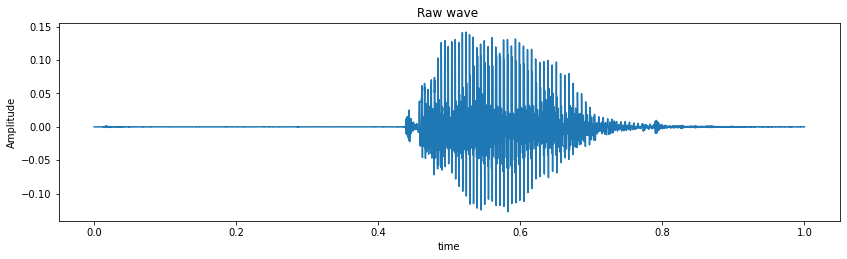

In [ ]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave ')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [ ]:
current_path = os.getcwd() 

negative_audio_path = '/content/drive/MyDrive/MCI/WordWakeup' +'/negative/'
positive_audio_path = '/content/drive/MyDrive/MCI/WordWakeup' +'/positive/'

label_dict = {'positive':1 , 'negative':0}
paths = {'positive':positive_audio_path , 'negative': negative_audio_path}

all_wave = []
all_label = []

for key,value in paths.items():
    for dirname, _, filenames in os.walk(value):
        for filename in filenames:
                samples, sample_rate = librosa.load(dirname+filename, sr = 16000)
                samples = librosa.resample(samples, sample_rate, 8000)
                if(len(samples)== 8000) : 
                    all_wave.append(samples)
                    all_label.append(label_dict[key])

In [ ]:
all_wave = np.asarray(all_wave).reshape(-1,8000,1)
all_label = np.asarray(all_label)

In [ ]:
np.unique(all_label,return_counts=True)

(array([0, 1]), array([2143, 2173]))

In [ ]:
# import torch 

# all_wave =  torch.Tensor(all_wave).reshape(-1,16000,1)
# all_label = torch.Tensor(all_label).reshape(-1,1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(all_wave,
                                                   all_label,
                                                   test_size = 0.2,
                                                   stratify = all_label,
                                                   random_state = 1,
                                                   shuffle = True)

x_train, x_val, y_train, y_val= train_test_split( x_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  stratify = y_train,
                                                  random_state=1,
                                                  shuffle = True) # 0.25 x 0.8 = 0.2


In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, BatchNormalization,Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', strides=1)(inputs)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)  
conv = Activation('relu')(conv)
conv = MaxPooling1D(3)(conv)


#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', strides=1)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)  
conv = Activation('relu')(conv)
conv = MaxPooling1D(3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', strides=1)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)  
conv = Activation('relu')(conv)
conv = MaxPooling1D(3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', strides=1)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)  
conv = Activation('relu')(conv)
conv = MaxPooling1D(3)(conv)

#Fourth Conv1D layer
conv = Conv1D(128, 3, padding='valid', strides=1)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)  
conv = Activation('relu')(conv)
conv = MaxPooling1D(3)(conv)


#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(1, activation='sigmoid')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 dropout (Dropout)           (None, 7988, 8)           0         
                                                                 
 batch_normalization (BatchN  (None, 7988, 8)          32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7988, 8)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                           

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
mc = ModelCheckpoint('/content/drive/MyDrive/MCI/wakeup_classify_best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history=model.fit(x_train, y_train ,epochs=50, batch_size=128,callbacks=[mc], validation_data=(x_val,y_val))

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 0.8561 - accuracy: 0.5404
Epoch 1: val_accuracy improved from -inf to 0.50521, saving model to /content/drive/MyDrive/MCI/wakeup_classify_best_model.hdf5
21/21 [==============================] - 20s 873ms/step - loss: 0.8561 - accuracy: 0.5404 - val_loss: 0.6930 - val_accuracy: 0.5052
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.6587 - accuracy: 0.6346
Epoch 2: val_accuracy did not improve from 0.50521
21/21 [==============================] - 17s 804ms/step - loss: 0.6587 - accuracy: 0.6346 - val_loss: 0.6932 - val_accuracy: 0.4959
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.7196
Epoch 3: val_accuracy improved from 0.50521 to 0.52955, saving model to /content/drive/MyDrive/MCI/wakeup_classify_best_model.hdf5
21/21 [==============================] - 17s 828ms/step - loss: 0.5698 - accuracy: 0.7196 - val_loss: 0.6900 - val_accuracy: 0.5295
Epoch 4/50
2

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/MCI/wakeup_classify_best_model.hdf5')
pred = model.predict(x_test)

27/27 [==============================] - 1s 42ms/step


In [ ]:
result = [1 if i >0.5 else 0 for i in pred]
count = 0
for i in range(len(result)):
  if(result[i] == y_test[i]):
    count+=1

print(f"accuracy test set is: {count/len(x_test) * 100}")

accuracy test set is: 88.42592592592592


In [ ]:
sample_path = '/content/drive/MyDrive/MCI/WordWakeup/positive/012c8314_nohash_0.wav'
samples, sample_rate = librosa.load(sample_path,sr = 16000)
samples_inp = librosa.resample(samples, sample_rate, 8000)
pred = model.predict(samples_inp.reshape(1,-1,1))
print('***************')
if(pred>0.5):
  print('Wakeup!')

ipd.Audio(samples, rate=sample_rate)

1/1 [==============================] - 0s 17ms/step
***************
Wakeup!
